In [13]:
import sys
from pathlib import Path

project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

import os
os.chdir(project_root)

In [14]:
import torch
import numpy as np
import yaml
from torch.utils.data import DataLoader

from src.data.pipeline import get_datasets
from src.models.transformer_model import StockTransformer
from src.simulation.engine import BacktestEngine
from src.simulation.metrics import compute_metrics
from src.utils.config import load_config

In [15]:
config = load_config()

# Use same project root as load_config() so path works regardless of cwd
from src.utils import config as _cfg
config_path = _cfg.PROJECT_ROOT / "configs" / "default_config.yaml"
with config_path.open("r", encoding="utf-8") as f:
    raw_cfg = yaml.safe_load(f)
sim = raw_cfg.get("simulation", {})

initial_capital = float(sim.get("initial_capital", 100_000))
position_size_pct = float(sim.get("position_size_pct", 1.0))
entry_threshold_pct = float(sim.get("entry_threshold_pct", 0.5))
exit_threshold_pct = float(sim.get("exit_threshold_pct", -0.5))
commission_pct = float(sim.get("commission_pct", 0.1))
risk_free_rate_annual = float(sim.get("risk_free_rate_annual", 0.03))

print("Simulation config:", initial_capital, position_size_pct, entry_threshold_pct, exit_threshold_pct, commission_pct)

Simulation config: 100000.0 1.0 0.5 -0.5 0.1


In [16]:
_, _, test_dataset, feature_columns = get_datasets(config)
print(f"Test samples: {len(test_dataset)}, features: {len(feature_columns)}")

Зареждане на dataset от Hugging Face: pmoe7/SP_500_Stocks_Data-ratios_news_price_10_yrs
Това може да отнеме няколко минути при първо зареждане...
Опитвам се да заредя само price данните...


Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/1048575 [00:00<?, ? examples/s]

Успешно зареден price dataset!
Dataset зареден. Конвертиране в pandas...
Конвертирано! Размер: (1048575, 23)
Филтриране на данни... Първоначален размер: (1048575, 25)
Филтрирано! Финален размер: (10068, 25)
Test samples: 1427, features: 34


In [19]:
# Use project root so path works regardless of cwd (same as config)
checkpoint_path = _cfg.PROJECT_ROOT / config.paths.models_dir / "best_model.pt"
checkpoint = torch.load(checkpoint_path, map_location="cpu")
state_dict = checkpoint["model_state_dict"]

input_dim_checkpoint = state_dict["input_projection.weight"].shape[1]
input_dim_current = len(feature_columns)
d_model = state_dict["input_projection.weight"].shape[0]
n_layers = len([k for k in state_dict if "encoder.layers" in k and "self_attention.w_q.weight" in k])
n_heads = config.model.n_heads
d_ff = state_dict["encoder.layers.0.feed_forward.linear1.weight"].shape[0]

if input_dim_checkpoint != input_dim_current:
    model = StockTransformer(
        input_dim=input_dim_current,
        d_model=d_model,
        n_heads=n_heads,
        n_layers=n_layers,
        d_ff=d_ff,
        dropout=config.model.dropout,
        activation=config.model.activation,
        prediction_horizon=config.data.prediction_horizon,
    )
    model_dict = model.state_dict()
    compatible_dict = {k: v for k, v in state_dict.items()
                      if k in model_dict and model_dict[k].shape == v.shape}
    model_dict.update(compatible_dict)
    model.load_state_dict(model_dict, strict=False)
    print(f"Loaded {len(compatible_dict)}/{len(state_dict)} params (input_dim mismatch: using current features)")
else:
    model = StockTransformer(
        input_dim=input_dim_checkpoint,
        d_model=d_model,
        n_heads=n_heads,
        n_layers=n_layers,
        d_ff=d_ff,
        dropout=config.model.dropout,
        activation=config.model.activation,
        prediction_horizon=config.data.prediction_horizon,
    )
    model.load_state_dict(state_dict)
    print("Model loaded.")
model.eval()

Loaded 100/101 params (input_dim mismatch: using current features)


StockTransformer(
  (input_projection): Linear(in_features=34, out_features=256, bias=True)
  (pos_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attention): MultiHeadAttention(
          (w_q): Linear(in_features=256, out_features=256, bias=True)
          (w_k): Linear(in_features=256, out_features=256, bias=True)
          (w_v): Linear(in_features=256, out_features=256, bias=True)
          (w_o): Linear(in_features=256, out_features=256, bias=True)
          (attention): ScaledDotProductAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): FeedForward(
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
          (dropout): Dropout(p=

In [20]:
test_loader = DataLoader(
    test_dataset,
    batch_size=config.training.batch_size,
    shuffle=False,
    num_workers=0,
)

all_predictions = []
all_targets = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        pred = model(batch_x)
        if pred.dim() == 1:
            pred = pred.unsqueeze(1)
        if batch_y.dim() == 1:
            batch_y = batch_y.unsqueeze(1)
        all_predictions.append(pred)
        all_targets.append(batch_y)

predictions = torch.cat(all_predictions, dim=0).numpy().flatten()
targets = torch.cat(all_targets, dim=0).numpy().flatten()

prices = targets[:-1]
pred_next = predictions[1:]
print(f"Backtest length: {len(prices)} days")

engine = BacktestEngine(
    initial_capital=initial_capital,
    position_size_pct=position_size_pct,
    entry_threshold_pct=entry_threshold_pct,
    exit_threshold_pct=exit_threshold_pct,
    commission_pct=commission_pct,
)

result = engine.run(prices=prices, predictions=pred_next)

metrics = compute_metrics(
    result,
    initial_capital=initial_capital,
    risk_free_rate_annual=risk_free_rate_annual,
    prices=prices,
)

print("=" * 50)
print("BACKTEST METRICS")
print("=" * 50)
print(f"Total return:        {metrics.total_return_pct:.2f}%")
print(f"Sharpe (annual):     {metrics.sharpe_ratio_annual:.3f}")
print(f"Max drawdown:        {metrics.max_drawdown_pct:.2f}%")
print(f"Number of trades:    {metrics.num_trades}")
if metrics.buy_and_hold_return_pct is not None:
    print(f"Buy & hold return:   {metrics.buy_and_hold_return_pct:.2f}%")
if metrics.excess_return_vs_bh_pct is not None:
    print(f"Excess vs B&H:       {metrics.excess_return_vs_bh_pct:+.2f}%")
print("=" * 50)

Backtest length: 1426 days
BACKTEST METRICS
Total return:        0.00%
Sharpe (annual):     0.000
Max drawdown:        0.00%
Number of trades:    0
Buy & hold return:   0.00%
Excess vs B&H:       +0.00%


In [5]:
# Run cell above (4) to compute prices, result, and metrics. Then run cell below for plots.

NameError: name 'prices' is not defined

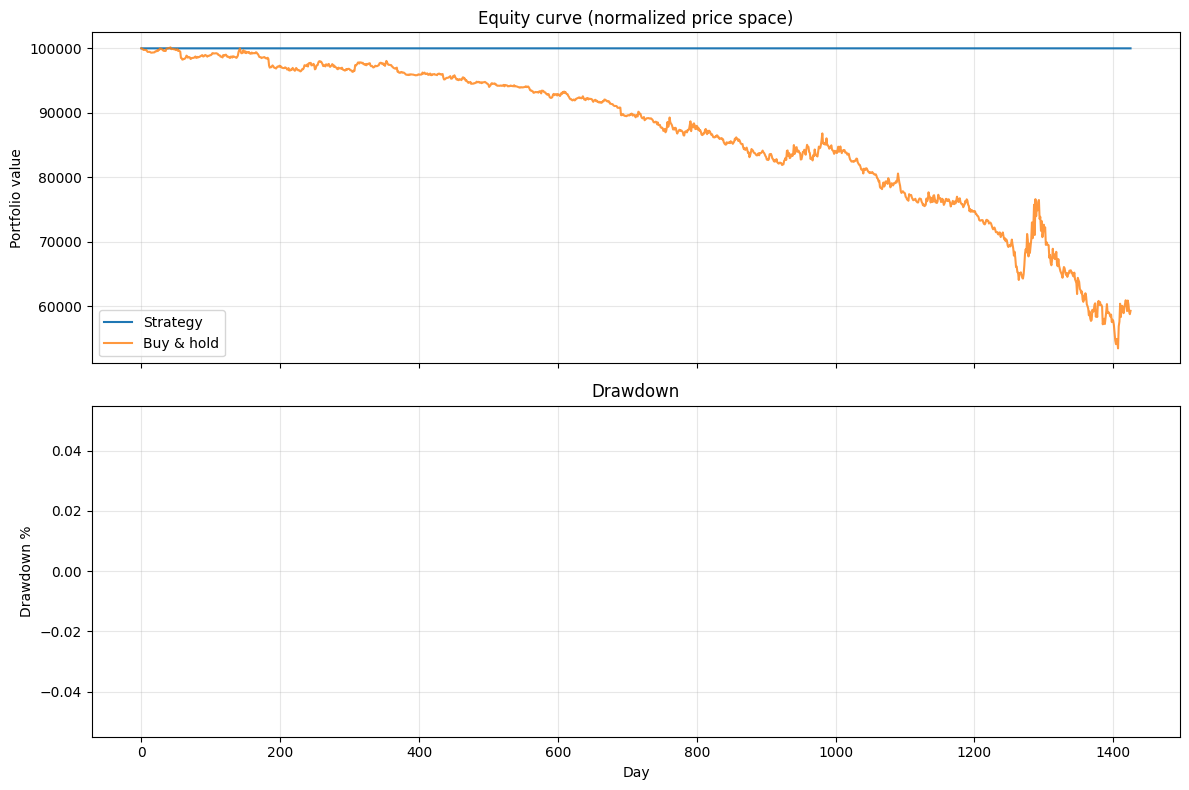

In [21]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1 = axes[0]
ax1.plot(result.equity_curve, label="Strategy")
bh_value = initial_capital * (prices / prices[0])
ax1.plot(bh_value, label="Buy & hold", alpha=0.8)
ax1.set_ylabel("Portfolio value")
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_title("Equity curve (normalized price space)")

ax2 = axes[1]
peak = np.maximum.accumulate(result.equity_curve)
dd = 100 * (peak - result.equity_curve) / np.where(peak <= 0, np.nan, peak)
ax2.fill_between(range(len(dd)), dd, 0, alpha=0.3)
ax2.set_ylabel("Drawdown %")
ax2.set_xlabel("Day")
ax2.grid(True, alpha=0.3)
ax2.set_title("Drawdown")

plt.tight_layout()
plt.show()